# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import json
import seaborn as sns
from PIL import Image
import copy
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.autograd import Variable
import operator


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left ')

CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left 


In [2]:
break

SyntaxError: 'break' outside loop (<ipython-input-2-6aaf1f276005>, line 1)

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [4]:
# define training and test data directories
data_dir = 'C:/PyTorch/flower_data/'
#data_dir = 'C:/PyTorch/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

In [5]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 40
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Num training images:  6553
Num valid images:  832
Num test images:  817


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
class_names = train_data.classes
#labelsr = list(cat_to_name.values())
#print(json.dumps(cat_to_name, sort_keys=True, indent=4, separators=(',', ': ')))
#print(json.dumps(class_names, sort_keys=False, indent=4, separators=(',', ': ')))

#sortedclasses = sorted(cat_to_name.items(), key=operator.itemgetter(0))
sortedclasses = sorted(cat_to_name.items())
print(sortedclasses[0])
#labelsr = list(sortedclasses)
#print(labelsr[:10])
#type(cat_to_name)

#type(sortedclasses)
#print(cat_to_name)
#print(sortedclasses)
#type(class_names)

#print(json.dumps(cat_to_name, sort_keys=False, indent=4, separators=(',', ': ')))
#print(json.dumps(class_names, sort_keys=False, indent=4, separators=(',', ': ')))
#print(json.dumps(sortedclasses, sort_keys=False, indent=4, separators=(',', ': ')))


('1', 'pink primrose')


### Visualize a Batch of Training Data

In [7]:
# helper function to un-normalize and display an image
def imshow(img):

    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)

    plt.imshow(img)  # convert from Tensor image

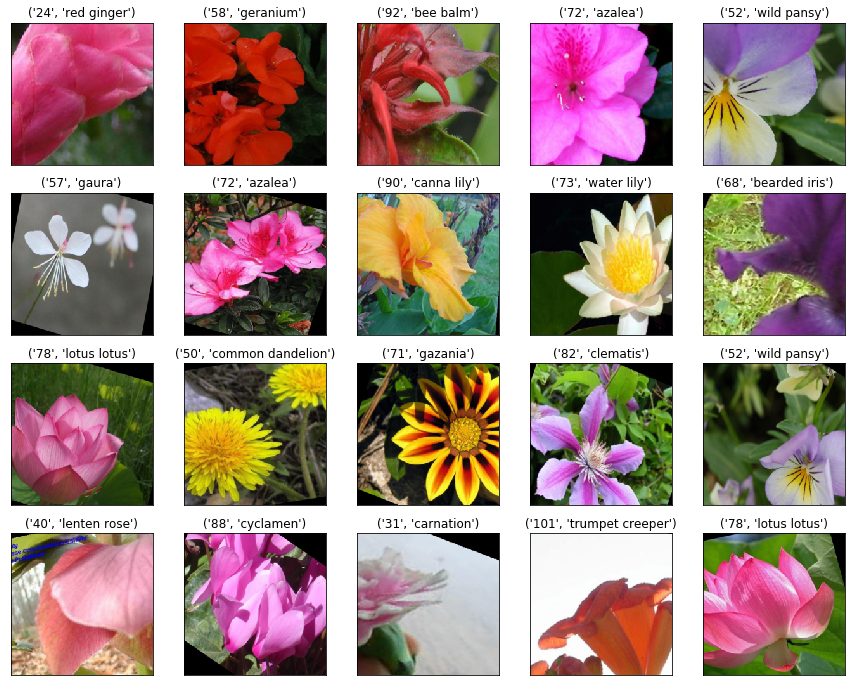

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 12))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
#   ax.set_title(classes[labels[idx]])
    #print('labels[idx] is ',labels[idx])
   # print('class 10 is ',classes['10'])
    #print('classes is ',classes[labels[idx]])
    #ax.set_title(classes[labels[idx]])
    #ax.set_title(labels[idx])
    ax.set_title(sortedclasses[labels[idx]])
    
    

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [9]:
# Load the pretrained model from pytorch
#vgg19 = models.vgg19(pretrained=True)
model = models.vgg19(pretrained=True)

# print out the model structure
#print(vgg19)

# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    
    
n_inputs = model.classifier[6].in_features
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features) 

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(cat_to_name))

model.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs
print(model.classifier[6].out_features)
print(model)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
#optimizer = optim.SGD(model.parameters(), lr=0.0005)
optimizer = optim.Adadelta(model.parameters(), lr=0.8, rho=0.9, eps=1e-06, weight_decay=0)

4096
1000
102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17):

In [10]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#model.load_state_dict(torch.load('model_augmented.pt'))
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint('BAMFFlowerPowerVgg19RevEv2.pth')

print(model)
for param in model.features.parameters():
    param.requires_grad = True
print(model.class_to_idx)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #    if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
     #       print('\t Epoch %d, Batch %d loss: %.16f' %
      #            (epoch, batch_idx + 1, train_loss / 20))
       #     print(f"\t \tTime per batch: {(time.time() - start)/3:.3f} seconds")
        #    train_loss = 0.0
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_augmented.pt')
        model.class_to_idx = train_data.class_to_idx
        #model.cpu()
        torch.save({'state_dict': model.state_dict(), 
                    'class_to_idx': model.class_to_idx}, 
                    'BAMFFlowerPowerVgg19RevEv2cont.pth')
        valid_loss_min = valid_loss
    
    print(f"Time per epoch: {(time.time() - start)/3:.3f} seconds")

In [11]:
def _plot_training(train_losses, valid_losses):
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title('Loss progress')
    plt.show()
    plt.savefig('progress.png')
    
_plot_training(train_loss,valid_loss)

NameError: name 'train_loss' is not defined

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx
        #model.cpu()
torch.save({'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'BAMFFlowerPower.pth')
print(model.class_to_idx)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#model.load_state_dict(torch.load('model_augmented.pt'))
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint('BAMFFlowerPowerVgg19RevEv2cont.pth')
print(model)
#print(model.class_to_idx)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [13]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(20):
    for i in range (len(target.data)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(102):
   if class_total[i] > 0:
       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           sortedclasses[i], 100 * class_correct[i] / class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
   else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
   100. * np.sum(class_correct) / np.sum(class_total),
   np.sum(class_correct), np.sum(class_total)))

Test Loss: 4.523289

Test Accuracy of ('1', 'pink primrose'):  0% ( 0/ 5)
Test Accuracy of ('10', 'globe thistle'):  0% ( 0/ 3)
Test Accuracy of ('100', 'blanket flower'):  0% ( 0/ 8)
Test Accuracy of ('101', 'trumpet creeper'):  0% ( 0/ 4)
Test Accuracy of ('102', 'blackberry lily'):  0% ( 0/ 6)
Test Accuracy of ('11', 'snapdragon'):  0% ( 0/ 9)
Test Accuracy of ('12', "colt's foot"):  0% ( 0/ 9)
Test Accuracy of ('13', 'king protea'):  0% ( 0/ 6)
Test Accuracy of ('14', 'spear thistle'):  0% ( 0/ 3)
Test Accuracy of ('15', 'yellow iris'):  0% ( 0/ 4)
Test Accuracy of ('16', 'globe-flower'):  0% ( 0/ 3)
Test Accuracy of ('17', 'purple coneflower'):  0% ( 0/ 9)
Test Accuracy of ('18', 'peruvian lily'):  0% ( 0/ 6)
Test Accuracy of ('19', 'balloon flower'):  0% ( 0/ 7)
Test Accuracy of ('2', 'hard-leaved pocket orchid'):  0% ( 0/ 5)
Test Accuracy of ('20', 'giant white arum lily'):  0% ( 0/ 3)
Test Accuracy of ('21', 'fire lily'):  0% ( 0/ 2)
Test Accuracy of ('22', 'pincushion flower')

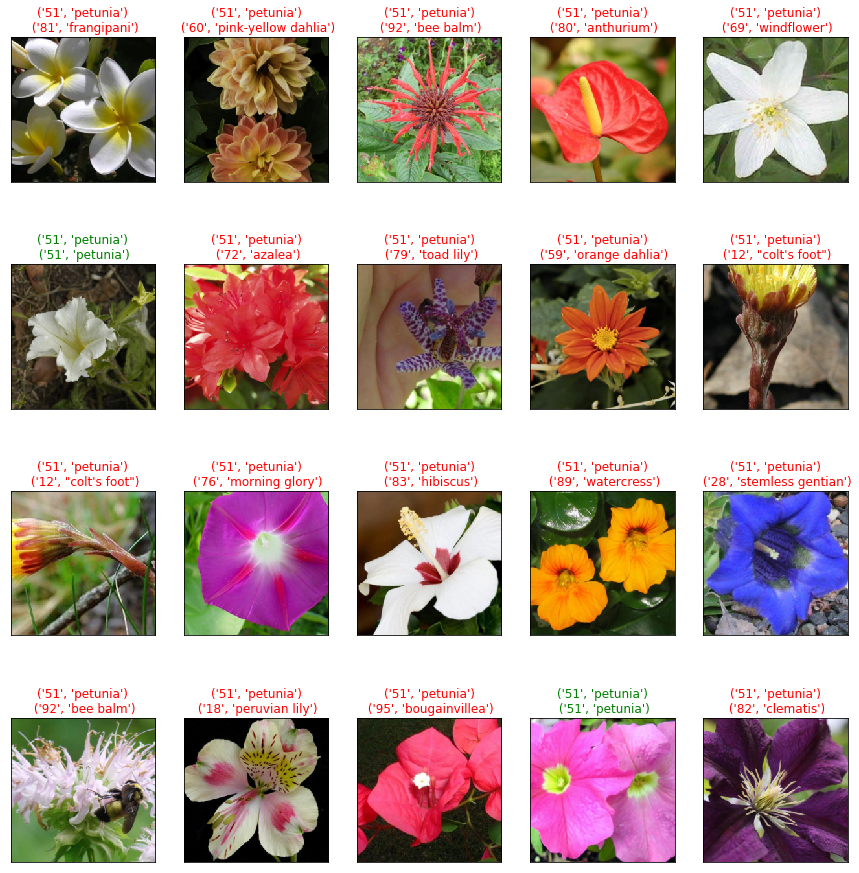

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 16))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    imshow(images[idx])
    ax.set_title("{}\n {}".format(sortedclasses[preds[idx]], sortedclasses[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
image_pathtet = os.path.join(data_dir, 'valid/34/image_06964.jpg')
imgtet = Image.open(image_pathtet)

In [ ]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img


In [ ]:
process_image(image_pathtet)
imshow(process_image(image_pathtet))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## doneabove

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes